## Exercise 8: Classification of Mental States using Machine Learning
**Objective:** Train a machine learning model to classify mental states based on EEG data.
- **Libraries:** `numpy`, `pandas`, `scikit-learn`
- **Tasks:**
  - Load a labeled EEG dataset.
  - Preprocess data (e.g., feature scaling).
  - Train a classifier (e.g., SVM or Random Forest) to predict mental states.
  - Evaluate the model's performance (accuracy, confusion matrix).
- **Expected Output:** Model accuracy score and confusion matrix.

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


### Load data 
from the [EEG brainwave (kaggle)](https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-mental-state/data)

In [29]:
features_path = 'data/mental-state.csv'
df = pd.read_csv(features_path)
df.head()

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,...,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,25.781648,33.836367,-92.769629,19.187957,-1.542262,0.197462,-119.561133,2.032654,21.596272,33.965587,...,0.000230,0.000351,0.000547,0.000381,0.000350,0.000453,0.000442,0.000325,0.000209,2.0
1,29.357891,26.792566,417.203910,19.472121,-38.797263,-16.897194,-29.368531,-9.055370,44.647424,40.893307,...,0.001671,0.000740,0.001122,0.000521,0.000624,0.000439,0.001249,0.000727,0.000801,2.0
2,28.451926,31.076434,72.231301,14.245938,-13.225057,-0.614138,-28.331698,-8.858742,31.450289,30.692883,...,0.000748,0.000569,0.000327,0.000197,0.000833,0.000909,0.000699,0.001165,0.000616,2.0
3,21.282184,19.985184,16.220094,39.787312,1.847866,0.670216,-1.820355,20.220724,21.404679,20.777411,...,0.000990,0.005644,0.006891,0.010546,0.009583,0.011158,0.008853,0.004551,0.002287,1.0
4,20.431516,28.982168,27.540246,19.960398,2.491458,-6.020503,-1.071166,2.655259,16.295039,32.658163,...,0.001659,0.014379,0.014492,0.002949,0.004575,0.008305,0.007202,0.006957,0.009836,2.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Columns: 989 entries, lag1_mean_0 to Label
dtypes: float64(989)
memory usage: 18.7 MB


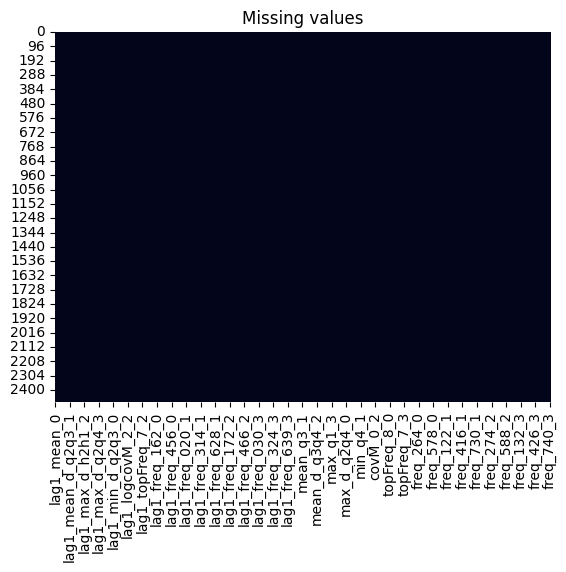

In [32]:
# visualize missing values with a heatmap
sns.heatmap(df.isnull(), cbar=False)
plt.title(f"Missing values")
plt.show()

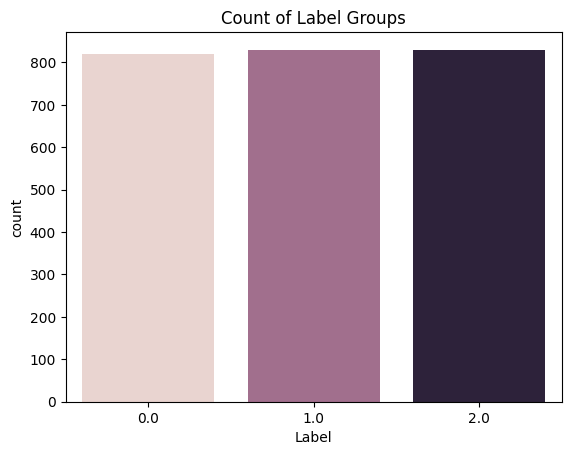

In [38]:
# label distribution 

sns.countplot(x='Label', hue='Label', data=df,legend=False)
plt.title("Count of Label Groups")
plt.show()

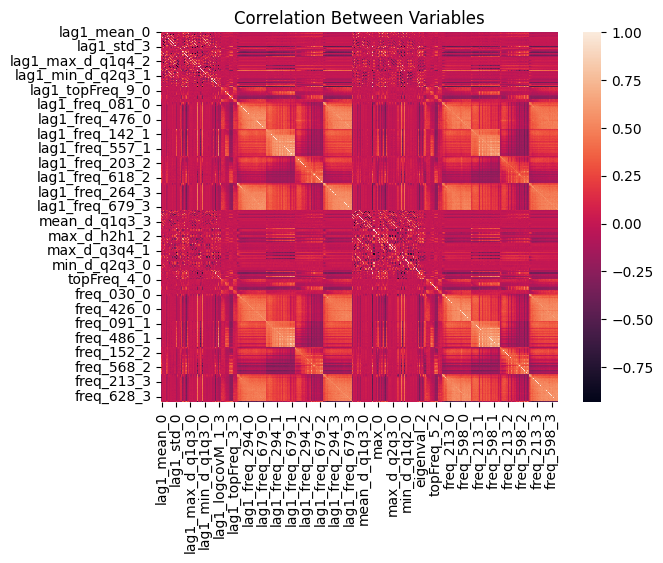

In [39]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix)
plt.title(f"Correlation Between Variables")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_13696\3273165993.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = correlations[sorted_indices]


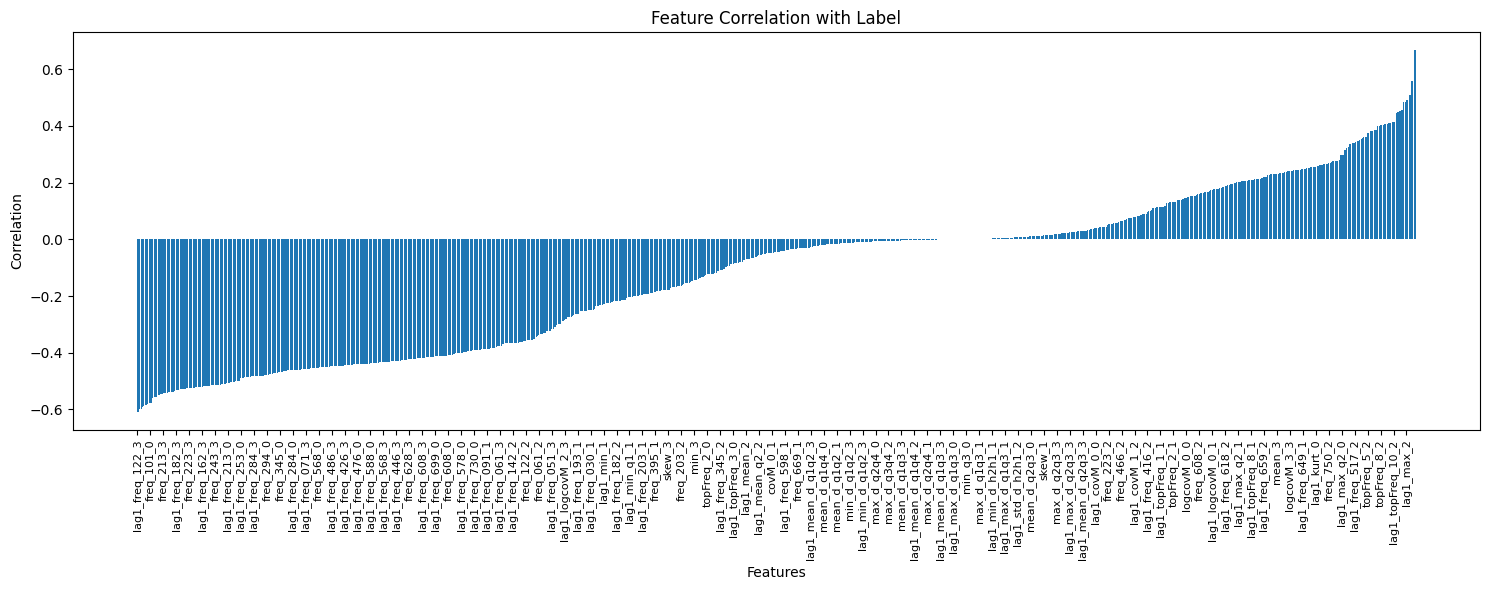

In [50]:
features_df = df.drop(columns=["Label"]) 
labels = df["Label"] 

correlations = features_df.apply(lambda x: np.corrcoef(x, labels)[0, 1])

sorted_indices = np.argsort(correlations)
sorted_correlations = correlations[sorted_indices]
sorted_features = np.array(features_df.columns)[sorted_indices]

plt.figure(figsize=(15, 6))
plt.bar(range(len(sorted_correlations)), sorted_correlations)
plt.xticks(ticks=np.arange(0, len(sorted_features), 10), 
           labels=sorted_features[::10], rotation=90, fontsize=8)
plt.title("Feature Correlation with Label")
plt.ylabel("Correlation")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

### Modeling

In [57]:
df_model = df.copy()

scaler = StandardScaler()
normalized_df_data = scaler.fit_transform(features_df.values)
df_model[features_df.columns] = normalized_df_data

In [58]:
X = df_model.drop(['Label'], axis=1)
y = df_model['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


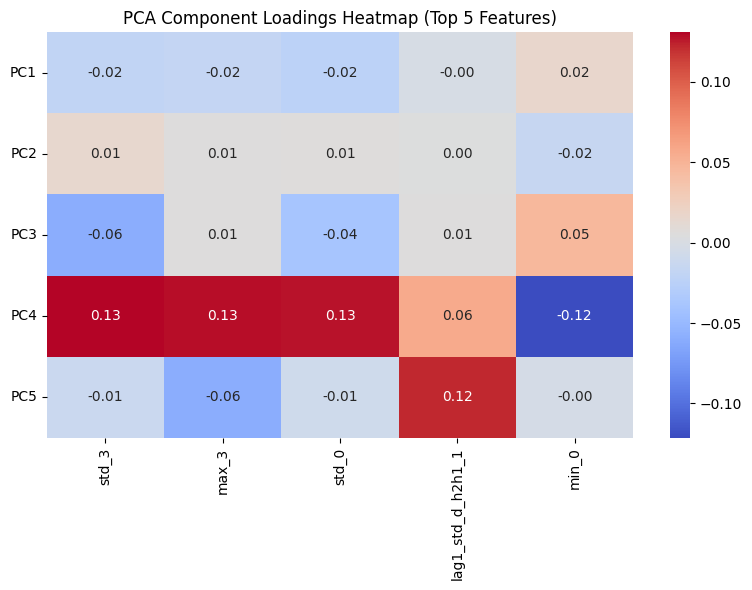

In [67]:
# perform pca 
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)
pca_components = pd.DataFrame(pca.components_, 
                              columns=X_train.columns, 
                              index=[f'PC{i+1}' for i in range(pca.n_components_)])

# plot pca results 
pca_subset = pca_components.iloc[:5, :]
sorted_columns = pca_subset.abs().max().sort_values(ascending=False).index[:5]
pca_sorted_subset = pca_subset[sorted_columns]
plt.figure(figsize=(8, 6))
sns.heatmap(pca_sorted_subset, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.title('PCA Component Loadings Heatmap (Top 5 Features)')
plt.tight_layout()
plt.show()

In [68]:
# organized train and test df after pca
pca_component_names = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
X_train_pca.columns = pca_component_names
X_test_pca.columns = pca_component_names

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(eval_metric='logloss')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid, cv=cv, 
                           scoring='accuracy')

grid_search.fit(X_train_pca, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_:.2f}")